In [1]:
import os
import numpy as np
import pandas as pd
from biopandas.pdb import PandasPdb
from biopandas.mmcif import PandasMmcif
import torch
import dgl
import tokenizers
import transformers
import os
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel, AutoConfig
from rdkit import Chem
import numpy as np
import os
from pathlib import Path
import dgl


def load_aaindex1(file_path):
    aaindex1_df = pd.read_csv(file_path, index_col='Description')
    aaindex_dict = {aa: aaindex1_df[aa].values for aa in aaindex1_df.columns}
    return aaindex_dict

def extract_features(sequence, aaindex_dict):
    features = []
    for aa in sequence:
        if aa in aaindex_dict:
            features.append(aaindex_dict[aa])
        else:
            features.append(np.full((len(next(iter(aaindex_dict.values()))),), np.nan))
    return np.array(features)

model = "/root/autodl-tmp/ToxGIN-main/ESM"
model = "facebook/esm2_t36_3B_UR50D"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = AutoTokenizer.from_pretrained(model)
config = AutoConfig.from_pretrained(model, output_hidden_states=True)
config.hidden_dropout = 0.
config.hidden_dropout_prob = 0.
config.attention_dropout = 0.
config.attention_probs_dropout_prob = 0.
encoder = AutoModel.from_pretrained(model, config=config).to(device).eval()
print("model loaded")

def seq_encode(seq):
    spaced_seq = " ".join(list(seq))
    inputs = tokenizer.encode_plus(
        spaced_seq, 
        return_tensors=None, 
        add_special_tokens=True,
        max_length=2000,
        padding=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    last_hidden_states = outputs[0]
    encoded_seq = last_hidden_states[inputs['attention_mask'].bool()][1:-1]
    return encoded_seq

def aggre(s):
    if type(s.values[0]) == str:
        return s.values[0]
    return np.mean(s)

aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}


cuda:0


2025-04-10 22:25:39.411458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 22:25:39.457838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 22:25:40.156191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/root/miniconda3/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still ch

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model loaded


In [2]:
def read_mol2_file(filename):
    atoms = []
    with open(filename, 'r') as f:
        all_line = f.read().split("\n")
        begin = False
        for line in all_line:
            if line.startswith("@<TRIPOS>ATOM"):
                begin = True
                continue
            if line.startswith("@<TRIPOS>BOND"):
                break
            if begin:
                atoms.append(line.rstrip())
    return atoms


atomlist = read_mol2_file('/root/autodl-tmp/ToxMol/dataset/coreset/1a30/1a30_ligand_opt.mol2')
for atom in atomlist:
    atomitem = atom.split()
    atomitem[5] = atomitem[5].split(".")[0]
    coordinate = atomitem[2:5]
    atom = atomitem[4]
    print(atomitem)


['1', 'N', '5.5200', '27.8370', '5.6740', 'N', '1', 'MOL', '-0.8530']
['2', 'CA', '6.1210', '26.6130', '5.0020', 'C', '1', 'MOL', '0.5640']
['3', 'C', '7.6400', '26.7060', '4.9190', 'C', '1', 'MOL', '0.5690']
['4', 'O', '8.2180', '27.6550', '4.4400', 'O', '1', 'MOL', '-0.5700']
['5', 'CB', '5.4450', '26.1250', '3.6950', 'C', '1', 'MOL', '0.0000']
['6', 'CG', '5.7650', '26.9790', '2.4420', 'C', '1', 'MOL', '-0.1060']
['7', 'CD', '4.7000', '26.9130', '1.3620', 'C', '1', 'MOL', '0.9060']
['8', 'OE1', '3.5480', '27.1160', '1.7070', 'O', '1', 'MOL', '-0.9000']
['9', 'OE2', '5.0490', '27.0360', '0.2050', 'O', '1', 'MOL', '-0.9000']
['10', 'N1', '8.2230', '25.7270', '5.6280', 'N', '1', 'MOL', '-0.7301']
['11', 'C1', '9.4390', '25.8710', '6.4450', 'C', '1', 'MOL', '0.3611']
['12', 'C3', '10.1410', '24.5210', '6.4460', 'C', '1', 'MOL', '0.5690']
['13', 'O1', '9.6330', '23.5470', '6.9900', 'O', '1', 'MOL', '-0.5700']
['14', 'C5', '9.0480', '26.3120', '7.8890', 'C', '1', 'MOL', '-0.1060']
['15', 

In [3]:
import re

def remove_adjacent_duplicates_regex(s):
    return re.sub(r'(.)\1+', r'\1', s)

In [4]:
import numpy as np
from scipy.spatial.distance import cdist
from rdkit import Chem
from rdkit.Chem import AllChem
# 亲和力预测
df = pd.read_csv('binding_affinity.csv')
pdb = None

aaindex_dict = load_aaindex1('aaindex1.csv')
scaler = MinMaxScaler()

valid_indices = []  # 记录有效处理的索引，后续可能需要更新数据框
train_data = {
    'target': [],
    'atoms': [],
    'coordinates': [],
    'features': [],
    'res_coords':[]
}
for index, row in df.iterrows():
    sequence = row.protein
    pdb_file = f'dataset/coreset/{sequence}/{sequence}_protein.pdb'    
    mol_file = f'dataset/coreset/{sequence}/{sequence}_ligand_opt.mol2'
    if not (os.path.exists(pdb_file) and os.path.exists(mol_file)):
        continue
    
    atom_df = PandasPdb().read_pdb(pdb_file).df['ATOM']
    ligand = read_mol2_file(mol_file)
    
    try:
        # 分组生成残基序列
        residue_df = atom_df.groupby('residue_number', as_index=False).agg(aggre).sort_values('residue_number')
        residue_df['letter'] = residue_df.residue_name.map(aa_map)
        pdb_seq = ''.join(residue_df['letter'].dropna())  # 残基的正确序列
        
        # 合并残基信息到 atom_df
        atom_df = atom_df.merge(residue_df[['residue_number', 'letter']], on='residue_number', how='left')
        
        # 检查 atom_df 中的重复
        unique_atom_df = atom_df.drop_duplicates(subset=['residue_number'], keep='first')  # 只保留每个残基的第一个原子记录
        count = ''.join(unique_atom_df['letter'].dropna())
        if len(count) != len(pdb_seq):
            print(f"序列不匹配: count={count}, pdb_seq={pdb_seq}")
            # 不强制同步，而是检查原因
            if len(unique_atom_df) != len(residue_df):
                print(f"警告: atom_df 去重后残基数 {len(unique_atom_df)} 与 residue_df {len(residue_df)} 不一致")
                # 如果有多条链，可以尝试只取第一条链
                chains = atom_df['chain_id'].unique()
                if len(chains) > 1:
                    print(f"PDB 文件包含多条链: {chains}")
                    atom_df = atom_df[atom_df['chain_id'] == chains[0]]  # 只取第一条链
                    unique_atom_df = atom_df.drop_duplicates(subset=['residue_number'], keep='first')
                    count = ''.join(unique_atom_df['letter'].dropna())
                    print(f"处理后: count={count}")
        
        # 提取坐标和特征
        res_coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
        atom_types = atom_df['element_symbol'].tolist()
        coords = atom_df[['x_coord', 'y_coord', 'z_coord']].values.tolist()
        # 添加配体信息
        for atom in ligand:
            atomitem = atom.split()
            atomitem[5] = atomitem[5].split(".")[0]
            coords.append(atomitem[2:5])
            atom_types.append(atomitem[5])
        
        # 编码序列并提取特征（基于 pdb_seq）
        encoded_pdb_seq = seq_encode(pdb_seq).cpu().numpy()
        features = extract_features(pdb_seq, aaindex_dict)
        combined_features = np.concatenate([encoded_pdb_seq, features], axis=-1)
        
        # 构建残基特征字典
        residue_features = {res_num: feat for res_num, feat in zip(residue_df['residue_number'], combined_features)}
        residue_coords = {res_num: coord for res_num, coord in zip(residue_df['residue_number'], res_coords)}
        
        # 为蛋白质原子分配特征
        protein_features = []
        coord_lis = []
        for _, atom in atom_df.iterrows():
            res_num = atom['residue_number']
            if res_num in residue_features:
                protein_features.append(residue_features[res_num])
                coord_lis.append(residue_coords[res_num])
            else:
                protein_features.append(np.zeros_like(combined_features[0]))  # 填充缺失值
                coord_lis.append(np.zeros(3))
                
        # 处理配体特征
        # 1. Morgan 指纹作为基础特征
        mol = Chem.MolFromMol2File(mol_file)
        if mol is None:
            raise ValueError(f"无法解析配体文件 {mol_file}")
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        mol_feature = np.array(fp)  # [2048]
        base_features = [mol_feature / mol.GetNumAtoms() for _ in range(len(ligand))]  # [num_ligand_atoms, 2048]
        
        # 2. 配体坐标
        ligand_coords = np.array([atom.split()[2:5] for atom in ligand], dtype=float)
        coord_lis.extend([np.mean(ligand_coords,axis=0)]*len(ligand_coords))
        # 3. 距离融合
        distances = cdist(ligand_coords, np.array(res_coords))
        ligand_features = []
        for i, dist in enumerate(distances):
            nearest_res_idx = np.argmin(dist)
            res_feature = combined_features[nearest_res_idx]  # [3113]
            base_feature = base_features[i]  # [2048]
            # 加权融合并调整维度
            ligand_feature = np.concatenate([0.7 * res_feature[:1065], base_feature])  # [3113]
            ligand_features.append(ligand_feature)
        
        # 拼接蛋白质和配体特征
        all_features = protein_features + ligand_features        
        # 检查特征长度
        if len(all_features) != len(atom_df)+len(ligand_features):
            print(f"特征长度 {len(feature)} 与原子数 {len(atom_df)} 不匹配")
        else:
            coords = list(map(lambda x:[float(x[0]),float(x[1]),float(x[2])],coords))
            coord_lis = list(map(lambda x:[float(x[0]),float(x[1]),float(x[2])],coord_lis))
            train_data['atoms'].append(atom_types)
            train_data['coordinates'].append(coords)
            train_data['features'].append(all_features)
            train_data['res_coords'].append(coord_lis)
            valid_indices.append(index)
        
        del atom_df
    except Exception as e:
        print(f"处理样本 {sequence} 时发生错误: {str(e)}")
        continue
df_valid = df.loc[valid_indices].reset_index(drop=True)
train_data['target'] = df_valid['label'].tolist()

[22:26:02] DEPRECATION WARNING: please use MorganGenerator
[22:26:03] DEPRECATION WARNING: please use MorganGenerator
[22:26:03] DEPRECATION WARNING: please use MorganGenerator
[22:26:04] DEPRECATION WARNING: please use MorganGenerator
[22:26:05] DEPRECATION WARNING: please use MorganGenerator
[22:26:06] DEPRECATION WARNING: please use MorganGenerator
[22:26:06] DEPRECATION WARNING: please use MorganGenerator
[22:26:08] DEPRECATION WARNING: please use MorganGenerator
[22:26:09] DEPRECATION WARNING: please use MorganGenerator
[22:26:10] DEPRECATION WARNING: please use MorganGenerator
[22:26:11] DEPRECATION WARNING: please use MorganGenerator
[22:26:11] DEPRECATION WARNING: please use MorganGenerator
[22:26:12] DEPRECATION WARNING: please use MorganGenerator
[22:26:13] DEPRECATION WARNING: please use MorganGenerator
[22:26:14] DEPRECATION WARNING: please use MorganGenerator
[22:26:14] DEPRECATION WARNING: please use MorganGenerator
[22:26:15] DEPRECATION WARNING: please use MorganGenerat

处理样本 1o0h 时发生错误: 无法解析配体文件 dataset/coreset/1o0h/1o0h_ligand_opt.mol2


[22:26:15] sanitize [22:26:15] 1o0h_ligand: [22:26:16] DEPRECATION WARNING: please use MorganGenerator
[22:26:16] DEPRECATION WARNING: please use MorganGenerator
[22:26:17] DEPRECATION WARNING: please use MorganGenerator
[22:26:17] DEPRECATION WARNING: please use MorganGenerator
[22:26:18] DEPRECATION WARNING: please use MorganGenerator
[22:26:19] DEPRECATION WARNING: please use MorganGenerator
[22:26:21] DEPRECATION WARNING: please use MorganGenerator
[22:26:22] DEPRECATION WARNING: please use MorganGenerator
[22:26:23] DEPRECATION WARNING: please use MorganGenerator
[22:26:23] DEPRECATION WARNING: please use MorganGenerator
[22:26:24] DEPRECATION WARNING: please use MorganGenerator
[22:26:25] DEPRECATION WARNING: please use MorganGenerator
[22:26:26] DEPRECATION WARNING: please use MorganGenerator
[22:26:26] DEPRECATION WARNING: please use MorganGenerator
[22:26:27] DEPRECATION WARNING: please use MorganGenerator
[22:26:28] DEPRECATION WARNING: please use MorganGenerator
[22:26:28] D

In [1]:
# 导入必要的模块
import numpy as np
import torch
from unimol_tool import UniMolRepr  # 假设这是UniMol工具的正确导入方式
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier  # 示例模型：随机森林
from sklearn.metrics import mean_squared_error  # 示例评估指标：均方误差
train_data = np.load('/root/autodl-tmp/ToxMol/data_raw.npy',allow_pickle=True).item()


log saved in /root/autodl-tmp/ToxMol/logs


2025-05-04 13:37:02 | unimol_tool/weights/weighthub.py | 17 | INFO | Uni-Mol Tools | Weights will be downloaded to default directory: /root/autodl-tmp/ToxMol/unimol_tool/weights


In [2]:
clf = UniMolRepr(
                 model_name='toxmol', # avaliable: unimolv1, unimolv2
                 model_size='84m', # work when model_name is unimolv2. avaliable: 84m, 164m, 310m, 570m, 1.1B.
                 )
unimol_repr = clf.get_repr(train_data, return_atomic_reprs=True)

2025-05-04 13:37:24 | unimol_tool/models/toxmol.py | 168 | INFO | Uni-Mol Tools | Loading pretrained weights from /root/autodl-tmp/ToxMol/unimol_tool/weights/modelzoo/best/checkpoint.pth
  1%|          | 1/139 [00:02<06:31,  2.84s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  1%|▏         | 2/139 [00:05<06:52,  3.01s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  2%|▏         | 3/139 [00:08<06:31,  2.88s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  3%|▎         | 4/139 [00:11<06:20,  2.81s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  4%|▎         | 5/139 [00:14<06:12,  2.78s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  4%|▍         | 6/139 [00:16<06:06,  2.76s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  5%|▌         | 7/139 [00:19<06:02,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  6%|▌         | 8/139 [00:22<05:58,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  6%|▋         | 9/139 [00:24<05:55,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  7%|▋         | 10/139 [00:27<05:52,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  8%|▊         | 11/139 [00:30<05:49,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  9%|▊         | 12/139 [00:33<05:46,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


  9%|▉         | 13/139 [00:35<05:43,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 10%|█         | 14/139 [00:38<05:40,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 11%|█         | 15/139 [00:41<05:38,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 12%|█▏        | 16/139 [00:44<05:35,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 12%|█▏        | 17/139 [00:46<05:32,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 13%|█▎        | 18/139 [00:49<05:30,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 14%|█▎        | 19/139 [00:52<05:27,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 14%|█▍        | 20/139 [00:55<05:25,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 15%|█▌        | 21/139 [00:57<05:22,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 16%|█▌        | 22/139 [01:00<05:19,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 17%|█▋        | 23/139 [01:03<05:16,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 17%|█▋        | 24/139 [01:05<05:14,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 18%|█▊        | 25/139 [01:08<05:11,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 19%|█▊        | 26/139 [01:11<05:09,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 19%|█▉        | 27/139 [01:14<05:06,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 20%|██        | 28/139 [01:16<05:03,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 21%|██        | 29/139 [01:19<05:00,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 22%|██▏       | 30/139 [01:22<04:58,  2.73s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 22%|██▏       | 31/139 [01:25<04:55,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 23%|██▎       | 32/139 [01:27<04:52,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 24%|██▎       | 33/139 [01:30<04:50,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 24%|██▍       | 34/139 [01:33<04:47,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 25%|██▌       | 35/139 [01:36<04:44,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 26%|██▌       | 36/139 [01:38<04:42,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 27%|██▋       | 37/139 [01:41<04:39,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 27%|██▋       | 38/139 [01:44<04:36,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 28%|██▊       | 39/139 [01:47<04:33,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 29%|██▉       | 40/139 [01:49<04:31,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 29%|██▉       | 41/139 [01:52<04:28,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 30%|███       | 42/139 [01:55<04:25,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 31%|███       | 43/139 [01:57<04:22,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 32%|███▏      | 44/139 [02:00<04:20,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 32%|███▏      | 45/139 [02:03<04:17,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 33%|███▎      | 46/139 [02:06<04:14,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 34%|███▍      | 47/139 [02:08<04:11,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 35%|███▍      | 48/139 [02:11<04:09,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 35%|███▌      | 49/139 [02:14<04:06,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 36%|███▌      | 50/139 [02:17<04:03,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 37%|███▋      | 51/139 [02:19<04:01,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 37%|███▋      | 52/139 [02:22<03:58,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 38%|███▊      | 53/139 [02:25<03:55,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 39%|███▉      | 54/139 [02:28<03:53,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 40%|███▉      | 55/139 [02:30<03:50,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 40%|████      | 56/139 [02:33<03:47,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 41%|████      | 57/139 [02:36<03:44,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 42%|████▏     | 58/139 [02:39<03:41,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 42%|████▏     | 59/139 [02:41<03:39,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 43%|████▎     | 60/139 [02:44<03:36,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 44%|████▍     | 61/139 [02:47<03:33,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 45%|████▍     | 62/139 [02:50<03:31,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 45%|████▌     | 63/139 [02:52<03:28,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 46%|████▌     | 64/139 [02:55<03:25,  2.74s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 47%|████▋     | 65/139 [02:58<03:23,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 47%|████▋     | 66/139 [03:01<03:20,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 48%|████▊     | 67/139 [03:03<03:18,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 49%|████▉     | 68/139 [03:06<03:15,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 50%|████▉     | 69/139 [03:09<03:12,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 50%|█████     | 70/139 [03:12<03:09,  2.75s/it]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


 50%|█████     | 70/139 [03:14<03:12,  2.78s/it]


KeyboardInterrupt: 

In [15]:
# 步骤2：定义K折交叉验证
k = 5  # 折数
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # 随机打乱数据

X = np.array(unimol_repr["cls_repr"])
Y = torch.tensor(unimol_repr["label"]).cpu().numpy()

# 步骤3：进行K折交叉验证
mse_scores = []  # 存储每次折的均方误差
for train_index, test_index in kf.split(X):
    # 分割训练集和测试集
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # 训练模型（这里使用随机森林作为示例）
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    # 在测试集上预测
    y_pred = model.predict(X_test)
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# 步骤4：计算平均性能
average_mse = sum(mse_scores) / len(mse_scores)
print(f"平均均方误差 (MSE) 跨 {k} 折: {average_mse}")

平均均方误差 (MSE) 跨 5 折: 0.0


In [3]:
print(unimol_repr.keys())

dict_keys(['cls_repr', 'atomic_coords', 'atomic_reprs', 'atomic_symbol', 'label'])


In [7]:
print(kf.split(unimol_repr["cls_repr"])[0])  #从原子图中获取的全局特征  (批次,特征数)

TypeError: 'generator' object is not subscriptable

In [51]:
print(len(unimol_repr["atomic_reprs"][0]))  #(4417,194/...,512)   (批次,原子数,特征数)

128


In [37]:
print(len(unimol_repr["atomic_coords"][0][0]))  #(批次,原子数,3)

3


In [46]:
print(len(unimol_repr["atomic_symbol"][0]))    #(批次,原子数)  ["C","H","O",....]

194


In [3]:
print(unimol_repr["label"])  

NameError: name 'unimol_repr' is not defined

In [7]:
import numpy as np
import random
data = {}
for i in range(len(train_data['TARGET'])):
    for key in train_data.keys():
        if len(train_data[key])<=i:
            continue
        if isinstance(train_data[key][i], list):
            train_data[key][i] = np.array(train_data[key][i])
        values = train_data[key][i]
        if isinstance(values, np.ndarray):
            data[key] = values.shape
        else:
            data[key] = values
    print(data)
    

{'atoms': (194,), 'coordinates': (194, 3), 'features': (194, 3113), 'res_coords': (194, 3), 'TARGET': 1}
{'atoms': (261,), 'coordinates': (261, 3), 'features': (261, 3113), 'res_coords': (261, 3), 'TARGET': 1}
{'atoms': (252,), 'coordinates': (252, 3), 'features': (252, 3113), 'res_coords': (252, 3), 'TARGET': 1}
{'atoms': (258,), 'coordinates': (258, 3), 'features': (258, 3113), 'res_coords': (258, 3), 'TARGET': 1}
{'atoms': (121,), 'coordinates': (121, 3), 'features': (121, 3113), 'res_coords': (121, 3), 'TARGET': 1}
{'atoms': (222,), 'coordinates': (222, 3), 'features': (222, 3113), 'res_coords': (222, 3), 'TARGET': 1}
{'atoms': (171,), 'coordinates': (171, 3), 'features': (171, 3113), 'res_coords': (171, 3), 'TARGET': 1}
{'atoms': (386,), 'coordinates': (386, 3), 'features': (386, 3113), 'res_coords': (386, 3), 'TARGET': 1}
{'atoms': (151,), 'coordinates': (151, 3), 'features': (151, 3113), 'res_coords': (151, 3), 'TARGET': 1}
{'atoms': (187,), 'coordinates': (187, 3), 'features': 

In [ ]:
import os
import torch
import numpy as np
from Bio.PDB import PDBParser
import esm
import torch.nn.functional as F

# Optional: for SHAP analysis
try:
    import shap
    from sklearn.ensemble import RandomForestClassifier
except ImportError:
    shap = None

# Optional: for visualization in Jupyter
try:
    import py3Dmol
except ImportError:
    py3Dmol = None

# Mapping from three-letter to one-letter codes
three_to_one_map = {
    'ALA':'A', 'CYS':'C', 'ASP':'D', 'GLU':'E', 'PHE':'F',
    'GLY':'G', 'HIS':'H', 'ILE':'I', 'LYS':'K', 'LEU':'L',
    'MET':'M', 'ASN':'N', 'PRO':'P', 'GLN':'Q', 'ARG':'R',
    'SER':'S', 'THR':'T', 'VAL':'V', 'TRP':'W', 'TYR':'Y'
}


def extract_sequence_from_pdb(pdb_path):
    """
    Parse PDB file and return the amino acid sequence (one-letter codes).
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(os.path.basename(pdb_path), pdb_path)
    seq = []
    for model in structure:
        for chain in model:
            for residue in chain:
                hetflag, resseq, icode = residue.get_id()
                if hetflag == ' ' and residue.resname in three_to_one_map:
                    seq.append(three_to_one_map[residue.resname])
    return ''.join(seq)


def get_esm_embeddings(sequence, model, batch_converter, repr_layer=33):
    """
    Given a protein sequence and a loaded ESM model, returns per-residue embeddings.
    """
    # ESM expects spaces between letters
    seq_spaced = ' '.join(list(sequence))
    batch_data = [("protein", seq_spaced)]
    _, _, tokens = batch_converter(batch_data)
    with torch.no_grad():
        results = model(tokens, repr_layers=[repr_layer], return_contacts=False)
    embeddings = results['representations'][repr_layer].squeeze(0)  # (L, D)
    return embeddings.cpu().numpy()


def compute_cosine_diff(emb1, emb2):
    """
    Compute per-residue cosine similarity difference between two embeddings.
    emb1, emb2: arrays of shape (L, D)
    Returns array of shape (L,): higher = more similar.
    """
    # Ensure same length
    L = min(emb1.shape[0], emb2.shape[0])
    emb1_trim = emb1[:L]
    emb2_trim = emb2[:L]
    cos_sim = F.cosine_similarity(
        torch.from_numpy(emb1_trim),
        torch.from_numpy(emb2_trim),
        dim=1
    ).numpy()
    return cos_sim


def shap_analysis(X, y, feature_names=None):
    """
    Train RandomForest on X (n_samples, n_features) and compute SHAP values.
    Returns shap_values object.
    """
    if shap is None:
        raise ImportError("SHAP or sklearn not installed.")
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X, y)
    explainer = shap.Explainer(model.predict, X)
    shap_values = explainer(X)
    return shap_values


def highlight_residues_in_3d(pdb_path, residues):
    """
    Visualize a PDB structure with important residues highlighted using py3Dmol.
    residues: list of 1-based residue indices to highlight.
    """
    if py3Dmol is None:
        raise ImportError("py3Dmol not installed.")
    view = py3Dmol.view(width=800, height=600)
    with open(pdb_path, 'r') as f:
        pdb_str = f.read()
    view.addModel(pdb_str, 'pdb')
    view.setStyle({'cartoon':{}})
    for resi in residues:
        view.addStyle({'resi': str(resi)}, {'stick':{'colorscheme':'magentaCarbon','radius':0.3}})
    view.zoomTo()
    return view


if __name__ == '__main__':
    # === User inputs ===
    root_dir = r'/root/autodl-tmp/ToxMol/train_structures/'
    toxic_pdb = root_dir + 'ACSGRGSRCPPQCCMGLTCGREYPPRC.pdb'      # Path to toxic protein PDB file
    nontoxic_pdb = root_dir + 'AAGELTLTQLESLREVCEANLACEDMMDAQGIIAAYTAYYGPIPY.pdb'  # Path to non-toxic protein PDB file

    # Load sequences
    seq_toxic = extract_sequence_from_pdb(toxic_pdb)
    seq_nontoxic = extract_sequence_from_pdb(nontoxic_pdb)
    print(f"Toxic sequence length: {len(seq_toxic)}")
    print(f"Non-toxic sequence length: {len(seq_nontoxic)}")

    # Load pretrained ESM-2 model
    print("Loading ESM model...")
#     model = "/root/autodl-tmp/ToxGIN-main/ESM"
#     model = "facebook/esm2_t36_3B_UR50D"
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#     print(device)

#     tokenizer = AutoTokenizer.from_pretrained(model)
#     config = AutoConfig.from_pretrained(model, output_hidden_states=True)
#     config.hidden_dropout = 0.
#     config.hidden_dropout_prob = 0.
#     config.attention_dropout = 0.
#     config.attention_probs_dropout_prob = 0.
#     encoder = AutoModel.from_pretrained(model, config=config).to(device).eval()
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()

    # Get embeddings
    emb_toxic = get_esm_embeddings(seq_toxic, model, batch_converter)
    emb_nontoxic = get_esm_embeddings(seq_nontoxic, model, batch_converter)

    # Compute cosine similarity per residue
    cos_sim = compute_cosine_diff(emb_toxic, emb_nontoxic)

    # Identify top differing residues (low similarity)
    L = len(cos_sim)
    top_k = 10
    worst_idxs = np.argsort(cos_sim)[:top_k] + 1  # 1-based positions
    print(f"Top {top_k} most differing residues (likely toxicity sites): {list(worst_idxs)}")

    # Optional: SHAP analysis if you have multiple examples
    # Example usage (uncomment if needed):
    # X = np.vstack([emb_toxic.mean(axis=1), emb_nontoxic.mean(axis=1)])  # shape (2, L)
    # y = np.array([1, 0])
    # shap_vals = shap_analysis(X, y)
    # shap.plots.bar(shap_vals)

    # Optional: visualize in 3D
    # view = highlight_residues_in_3d(toxic_pdb, list(worst_idxs))
    # view.show()


In [11]:
import os
import numpy as np
import pandas as pd
import torch
import dgl
from transformers import AutoTokenizer, AutoModel, AutoConfig
from sklearn.preprocessing import MinMaxScaler
import shap
import matplotlib.pyplot as plt

# 加载模型和分词器（保持原代码）
model_name = "facebook/esm2_t36_3B_UR50D"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)
config.hidden_dropout = 0.
config.hidden_dropout_prob = 0.
config.attention_dropout = 0.
config.attention_probs_dropout_prob = 0.
encoder = AutoModel.from_pretrained(model_name, config=config).to(device).eval()
print("Model loaded")

# 氨基酸映射（保持原代码）
aa_map = {'VAL': 'V', 'PRO': 'P', 'ASN': 'N', 'GLU': 'E', 'ASP': 'D', 'ALA': 'A', 'THR': 'T', 'SER': 'S',
          'LEU': 'L', 'LYS': 'K', 'GLY': 'G', 'GLN': 'Q', 'ILE': 'I', 'PHE': 'F', 'CYS': 'C', 'TRP': 'W',
          'ARG': 'R', 'TYR': 'Y', 'HIS': 'H', 'MET': 'M'}




Using device: cuda:0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


Analyzing Toxic Protein...
Toxic Protein Key Residues (Attention): [(9, 'P', 1.0), (14, 'M', 0.9997255), (17, 'T', 0.99993294)]


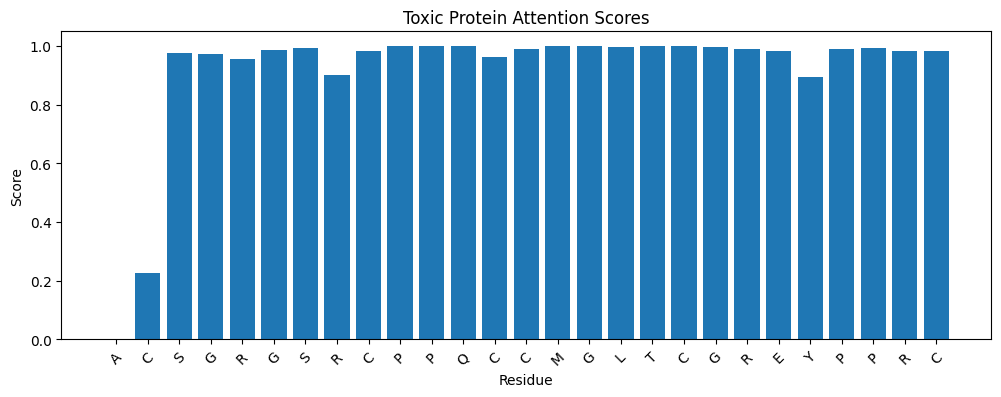

Input IDs shape: torch.Size([1, 29])
Attention Mask shape: torch.Size([1, 29])
Model output shape: torch.Size([1, 27])


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [16]:
# 示例序列（有毒和无毒蛋白质序列）
toxic_seq = "ACSGRGSRCPPQCCMGLTCGREYPPRC"  # 替换为实际有毒序列
non_toxic_seq = "AAGELTLTQLESLREVCEANLACEDMMDAQGIIAAYTAYYGPIPY"  # 替换为实际无毒序列

# 序列编码函数
def seq_encode(seq, return_attentions=False):
    spaced_seq = " ".join(list(seq))
    inputs = tokenizer.encode_plus(
        spaced_seq,
        return_tensors="pt",
        add_special_tokens=True,
        max_length=2000,
        padding=True,
        truncation=True
    ).to(device)
    
    with torch.no_grad():
        outputs = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], output_attentions=True)
    
    last_hidden_states = outputs[0]
    encoded_seq = last_hidden_states[inputs['attention_mask'].bool()][1:-1]
    attentions = outputs.attentions if return_attentions else None
    return encoded_seq, attentions, inputs

# 获取注意力权重并分析关键残基
def analyze_attention(attentions, seq, layer_idx=-1, head_idx=0):
    attention = attentions[layer_idx][0, head_idx].cpu().numpy()
    attention = attention[1:-1, 1:-1]
    seq_len = len(seq)
    attention_scores = np.mean(attention, axis=1)
    scaler = MinMaxScaler()
    attention_scores = scaler.fit_transform(attention_scores.reshape(-1, 1)).flatten()
    threshold = np.percentile(attention_scores, 90)
    key_residues = [(i, seq[i], attention_scores[i]) for i in range(seq_len) if attention_scores[i] >= threshold]
    return attention_scores, key_residues

# 自定义模型包装器
class ESMWrapper(torch.nn.Module):
    def __init__(self, esm_model):
        super(ESMWrapper, self).__init__()
        self.esm_model = esm_model
    
    def forward(self, input_ids, attention_mask=None):
        outputs = self.esm_model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs[0][:, 1:-1, :].mean(dim=-1)  # [batch_size, seq_len]
        return hidden_states

# 修改后的SHAP分析函数，使用GradientExplainer
def analyze_shap(seq, model, tokenizer):
    """
    使用SHAP GradientExplainer分析每个残基对模型输出的贡献。
    :param seq: 输入序列
    :param model: ESM2模型
    :param tokenizer: 分词器
    :return: SHAP值和关键残基
    """
    # 包装ESM模型
    wrapped_model = ESMWrapper(model).to(device).eval()
    
    # 准备输入数据
    spaced_seq = " ".join(list(seq))
    inputs = tokenizer.encode_plus(
        spaced_seq,
        return_tensors="pt",
        add_special_tokens=True,
        max_length=2000,
        padding=True,
        truncation=True
    ).to(device)
    
    # 检查输入维度
    print(f"Input IDs shape: {inputs['input_ids'].shape}")
    print(f"Attention Mask shape: {inputs['attention_mask'].shape}")
    
    # 前向传播检查输出维度
    with torch.no_grad():
        output = wrapped_model(inputs['input_ids'], inputs['attention_mask'])
    print(f"Model output shape: {output.shape}")
    
    # 创建SHAP解释器
    explainer = shap.GradientExplainer(wrapped_model, [inputs['input_ids'], inputs['attention_mask']])
    
    # 计算SHAP值
    shap_values = explainer.shap_values([inputs['input_ids'], inputs['attention_mask']])
    
    # 提取序列部分的SHAP值（去掉CLS和SEP）
    shap_values_input_ids = shap_values[0][0, 1:-1]  # [seq_len]
    shap_scores = np.abs(shap_values_input_ids)  # 取绝对值
    
    # 归一化SHAP得分
    scaler = MinMaxScaler()
    shap_scores = scaler.fit_transform(shap_scores.reshape(-1, 1)).flatten()
    
    # 识别关键残基（前10%）
    threshold = np.percentile(shap_scores, 90)
    key_residues = [(i, seq[i], shap_scores[i]) for i in range(len(seq)) if shap_scores[i] >= threshold]
    
    return shap_scores, key_residues

# 可视化函数
def visualize_scores(seq, scores, title, save_path=None):
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(seq)), scores, tick_label=list(seq))
    plt.title(title)
    plt.xlabel("Residue")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# 主分析流程
def analyze_proteins(toxic_seq, non_toxic_seq):
    print("Analyzing Toxic Protein...")
    toxic_encoded, toxic_attentions, toxic_inputs = seq_encode(toxic_seq, return_attentions=True)
    toxic_attention_scores, toxic_attention_residues = analyze_attention(toxic_attentions, toxic_seq)
    print("Toxic Protein Key Residues (Attention):", toxic_attention_residues)
    visualize_scores(toxic_seq, toxic_attention_scores, "Toxic Protein Attention Scores", "toxic_attention.png")
    
    toxic_shap_scores, toxic_shap_residues = analyze_shap(toxic_seq, encoder, tokenizer)
    print("Toxic Protein Key Residues (SHAP):", toxic_shap_residues)
    visualize_scores(toxic_seq, toxic_shap_scores, "Toxic Protein SHAP Scores", "toxic_shap.png")
    
    print("\nAnalyzing Non-Toxic Protein...")
    non_toxic_encoded, non_toxic_attentions, non_toxic_inputs = seq_encode(non_toxic_seq, return_attentions=True)
    non_toxic_attention_scores, non_toxic_attention_residues = analyze_attention(non_toxic_attentions, non_toxic_seq)
    print("Non-Toxic Protein Key Residues (Attention):", non_toxic_attention_residues)
    visualize_scores(non_toxic_seq, non_toxic_attention_scores, "Non-Toxic Protein Attention Scores", "non_toxic_attention.png")
    
    non_toxic_shap_scores, non_toxic_shap_residues = analyze_shap(non_toxic_seq, encoder, tokenizer)
    print("Non-Toxic Protein Key Residues (SHAP):", non_toxic_shap_residues)
    visualize_scores(non_toxic_seq, non_toxic_shap_scores, "Non-Toxic Protein SHAP Scores", "non_toxic_shap.png")
    
    print("\nComparison of Key Residues:")
    print("Toxic Attention Residues:", toxic_attention_residues)
    print("Non-Toxic Attention Residues:", non_toxic_attention_residues)
    print("Toxic SHAP Residues:", toxic_shap_residues)
    print("Non-Toxic SHAP Residues:", non_toxic_shap_residues)

# 运行分析
analyze_proteins(toxic_seq, non_toxic_seq)